<a id='top'></a><a name='top'></a>
# Chapter 7: How to Explain a Text Classifier

Book: [Blueprints for Text Analysis Using Python](https://www.oreilly.com/library/view/blueprints-for-text/9781492074076/)

Repo: https://github.com/blueprints-for-text-analytics-python/blueprints-text

* [Introduction](#introduction)
* [7.0 Imports and Setup](#7.0)
* [7.1 Blueprint: Determining Classification Confidence Using Prediction Probability](#7.1)
* [7.2 Blueprint: Measuring Feature Importance of Predictive Models](#7.2)
* [7.3 Blueprint: Using LIME to Explain the Classification Results](#7.3)
* [7.4 Blueprint: Using ELI5 to Explain the Classification Results](#7.4)
* [7.5 Blueprint: Using Anchor to Explain the Classification Results](#7.5)
    - [7.5.1 Using the Distribution with Masked Words](#7.5.1)
    - [7.5.2 Working with Real Words (broken) ](#7.5.2)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Dataset 

* Java Development Tools Bug dataset: [script](#eclipse_jdt.csv.gz), [source](https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/jdt-bugs-dataset/eclipse_jdt.csv.gz)

### Explore

* Explaining the results of supervised ML models.
* Analyzing which features are responsible for model outputs.
* Calculating feature-results using SVM.
* LIME (local interpretable model-agnostic explanations) model.
* Anchor model.

---
<a name='7.0'></a><a id='7.0'></a>
# 7.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
# Start with clean project
# !rm -f *.gz
# !rm -f *.py
# !rm -f *.txt

In [2]:
req_file = "requirements_07.txt"

In [3]:
%%writefile {req_file}
anchor-exp
# eli5
isort
lime
tqdm
transformers
watermark

Overwriting requirements_07.txt


In [4]:
import sys

IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
%%writefile imports.py
import html
import locale
import pprint
import re
import time
import warnings
# import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import transformers
from anchor import anchor_text
from lime import submodular_pick
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from tqdm.auto import tqdm
from watermark import watermark

Overwriting imports.py


In [6]:
!isort imports.py
!cat imports.py

Fixing /Users/gpb/Desktop/NLP-LEARNING/nlp-study/blueprints_for_text_analysis/ch07_Explaining_Text_Classifier/imports.py
import html
import locale
import pprint
import re
import time
import warnings

# import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import transformers
from anchor import anchor_text
from lime import submodular_pick
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from tqdm.auto import tqdm
from watermark import watermark


In [7]:
import html
import locale
import pprint
import re
import time
import warnings

# import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import transformers
from anchor import anchor_text
from lime import submodular_pick
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from tqdm.auto import tqdm
from watermark import watermark

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [8]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
BASE_DIR = '.'
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)

print(watermark(iversions=True, globals_=globals(),python=True, machine=True))

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

Compiler    : Clang 14.0.0 (clang-1400.0.29.202)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

lime        : 0.2.0.1
spacy       : 3.7.4
numpy       : 1.26.0
re          : 2.2.1
transformers: 4.46.1
matplotlib  : 3.9.2
seaborn     : 0.13.2
sys         : 3.11.5 (main, Jan 16 2024, 17:25:53) [Clang 14.0.0 (clang-1400.0.29.202)]
pandas      : 2.2.2



In [9]:
# Misc downloads
# !python -m spacy download en_core_web_lg >> /dev/null 2>&1
# !python -m spacy download en_core_web_lg
# nlp = spacy.load('en_core_web_lg')
# !python -m spacy download en_core_web_sm

try:
    nlp = spacy.load('en_core_web_lg')
except Exception as e:
    print(e)
    print("Loading download en_core_web_lg")
    !python -m spacy download en_core_web_lg
    nlp = spacy.load('en_core_web_lg')

print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [10]:
# Cleaning up the data to remove special characters - will re-use the blueprint from Chapter 5

# tags like 
RE_TAG = re.compile(r'<[^<>]*>')

# text or code in brackets like [0]
RE_BRACKET = re.compile('\[[^\[\]]*\]')

# text or code in brackets like (0)
RE_BRACKET_1 = re.compile('\([^)]*\)')

# specials that are not part of words; matches # but not #cool
RE_SPECIAL = re.compile(r'(?:^|\s)[&#<>{}\[\]+]+(?:\s|$)')

# standalone sequences of hyphens like --- or ==
RE_HYPHEN_SEQ = re.compile(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)')

# sequences of white spaces
RE_MULTI_SPACE = re.compile('\s+')

def clean(text):
    text = html.unescape(text)
    text = RE_TAG.sub(' ', text)
    text = RE_BRACKET.sub(' ', text)
    text = RE_BRACKET_1.sub(' ', text)
    text = RE_SPECIAL.sub(' ', text)
    text = RE_HYPHEN_SEQ.sub(' ', text)
    text = RE_MULTI_SPACE.sub(' ', text)
    return text.strip()

<a name='7.1'></a><a id='7.1'></a>
# 7.1 Determining Classification Confidence Using Prediction Probability
<a href="#top">[back to top]</a>

Here we train a SVM with optimized parameters (found in Chp 6). That model had a good average precision and recall of 75%, so the classification worked well.

We will use the function `predict_proba` of the support vector machine model, which tells us about the internals of the SVM, namely, the probabilities it calulated for the respective classes

<a id='eclipse_jdt.csv.gz'></a><a name='eclipse_jdt.csv.gz'></a>
### Dataset: eclipse_jdt.csv.gz
<a href="#top">[back to top]</a>

In [11]:
BUGS_FILE = 'eclipse_jdt.csv.gz'
!wget -nc -q https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/jdt-bugs-dataset/eclipse_jdt.csv.gz
!ls -l {BUGS_FILE}

-rw-r--r--  1 gpb  staff  13689872 11  2 22:15 eclipse_jdt.csv.gz


Part 1: Construct a DataFrame from the prediction results.

In [12]:
# Loads the dataframe
df = pd.read_csv(BUGS_FILE)

# Ensure we can run to completion on COLAB by reducing dataset size
df = df.sample(frac=0.5, replace=True, random_state=42)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22648 entries, 15795 to 29910
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Issue_id          22648 non-null  int64  
 1   Priority          22648 non-null  object 
 2   Component         22648 non-null  object 
 3   Duplicated_issue  3894 non-null   float64
 4   Title             22648 non-null  object 
 5   Description       22627 non-null  object 
 6   Status            22648 non-null  object 
 7   Resolution        22648 non-null  object 
 8   Version           22648 non-null  object 
 9   Created_time      22648 non-null  object 
 10  Resolved_time     22648 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 2.1+ MB


In [13]:
df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample, random_state=42, frac=.2)
df = df[['Title','Description','Component']]
df = df.dropna()
df['text'] = df['Title'] + " " + df['Description']
df = df.drop(columns=['Title','Description'])
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4526 entries, (0, 37285) to (5, 10114)
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Component  4526 non-null   object
 1   text       4526 non-null   object
dtypes: object(2)
memory usage: 246.9+ KB


In [14]:
# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(
    df['text'], 
    df['Component'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['Component']
)

print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])

Size of Training Data  3620
Size of Test Data  906


In [15]:
# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
print("Done initiating TfidfVectorizer model")
HR()


X_train_tf = tfidf.fit_transform(X_train)
print("Done fitting TfidfVectorizer model")

Done initiating TfidfVectorizer model
----------------------------------------
Done fitting TfidfVectorizer model


In [16]:
svc = SVC(
    kernel="linear", 
    C=1, 
    probability=True, 
    random_state=42,
    verbose=False
)
print("Done initiating SVC model")

Done initiating SVC model


In [17]:
svc.fit(X_train_tf, Y_train)
print("Done fitting SVC model")

Done fitting SVC model


---
Create a DataFrame from the prediction results.

In [18]:
X_test_tf = tfidf.transform(X_test)

Y_pred = svc.predict(X_test_tf)

result = pd.DataFrame({ 
    'text': X_test.values, 
    'actual': Y_test.values, 
    'predicted': Y_pred 
})

result

,text,actual,predicted
0,Control Backspace deletes text AFTER the curso...,Text,Text
1,Displaying a variable appends to same line Whi...,Debug,Debug
2,MalformedTreeException when formatting an inva...,Core,Core
3,Comment adjustment should handle single line t...,Text,Text
4,ClassCastException in CompletionEngine Build 2...,Core,UI
...,...,...,...
901,refactoringContribution.createDescriptor retur...,UI,Core
902,IllegalArgumentException during selection Buil...,Core,UI
903,Templates - JavaDoc should not be default type...,UI,UI
904,Reliable way to crash eclispe My workspace con...,UI,UI


In [19]:
result.head()

,text,actual,predicted
0,Control Backspace deletes text AFTER the curso...,Text,Text
1,Displaying a variable appends to same line Whi...,Debug,Debug
2,MalformedTreeException when formatting an inva...,Core,Core
3,Comment adjustment should handle single line t...,Text,Text
4,ClassCastException in CompletionEngine Build 2...,Core,UI


Examine cases where the predictions are wrong.

In [20]:
result[result["actual"] != result["predicted"]].head()

,text,actual,predicted
4,ClassCastException in CompletionEngine Build 2...,Core,UI
9,generated source folder should be marked as de...,APT,UI
24,Delete fails and Blocks the application I copi...,Text,Debug
25,Syntax highlighting glitch Create a class call...,UI,Core
28,HTML format hovering help Hi;; We are developi...,Text,UI


Examine Document 21.

In [21]:
text = result.iloc[21]["text"]
print(text)

shortkey for code formater Hi; Eclipse provides the format function like in Visual Age with more ; options. But the shortkey W doesnt work. I would ; really like if that was included into Eclipse.; ; Thanks; Thierry.; ; As well; it would be very great if there was a shortkey editor.


This example contains words that infer both Core and UI. Examine the probabilities via `predict_proba` for more details.

In [22]:
svc.predict_proba(X_test_tf[21])

array([[0.0010555 , 0.08415967, 0.02702105, 0.00065631, 0.34420308,
        0.54290439]])

Calculate the decision probability for all documents in the test dataset and add it to a DataFrame:

In [23]:
class_names = ["APT", "Core", "Debug", "Doc", "Text", "UI"]
prob = svc.predict_proba(X_test_tf)

# New dataframe for explainable results
er = result.copy().reset_index()
for i, c in enumerate(class_names):
    er[c] = prob[:, i]

Take a look at some samples of the dataframe and explore whether the predictions are better if the algo was certain about its decision.


In [24]:
er[["actual", "predicted"] + class_names].sample(5, random_state=99)

,actual,predicted,APT,Core,Debug,Doc,Text,UI
63,Text,Text,0.005743,0.111334,0.009894,0.004633,0.694708,0.173688
126,UI,UI,0.003290,0.263204,0.010302,0.000925,0.033111,0.689167
219,Debug,Debug,0.000992,0.001132,0.991699,0.003557,0.001699,0.000922
266,UI,UI,0.003899,0.410871,0.074245,0.000936,0.028525,0.481525
743,Debug,Debug,0.001454,0.004087,0.985459,0.000171,0.002402,0.006428


Build two DataFrames, one with correct and another with wrong predictions. Next, analyze the distribution of the highest probability and see whether there are any differences. 

In [25]:
er['max_probability'] = er[class_names].max(axis=1)
correct = (er[er['actual'] == er['predicted']])
wrong   = (er[er['actual'] != er['predicted']])

Plot as a histogram.

In the case of correct predictions, the model often decided with high probabilities. 

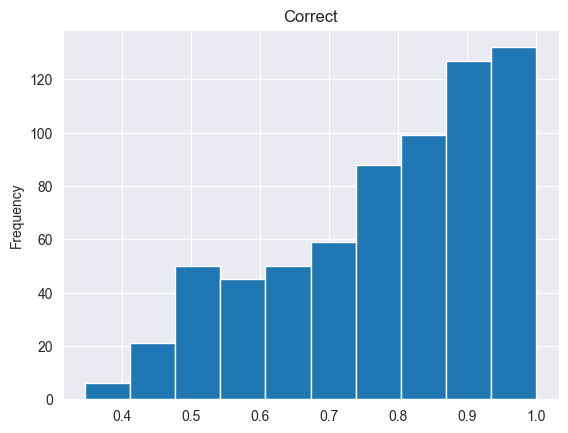

In [26]:
import matplotlib.pyplot as plt
correct["max_probability"].plot.hist(title="Correct")
plt.show()

---
In the case of wrong predictions, the model decided with much lower probabilities. 

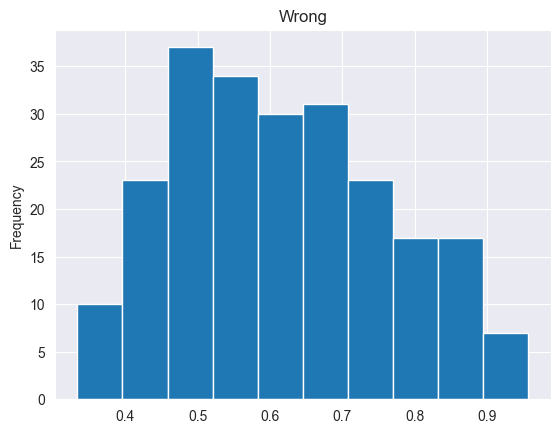

In [27]:
wrong["max_probability"].plot.hist(title="Wrong")
plt.show()

In [28]:
len(correct)

677

In [29]:
len(wrong)

229

---
Check whether we can improve the results if we only consider decisions that have been made with a probability of more than 80%. 

In [30]:
high = er[er["max_probability"] > 0.8]

In [31]:
len(high)

394

Updated results.

In [32]:
print(classification_report(high["actual"], high["predicted"]))

              precision    recall  f1-score   support

         APT       0.50      0.50      0.50         2
        Core       0.95      0.91      0.93       117
       Debug       0.94      1.00      0.97        97
         Doc       0.50      0.33      0.40         3
        Text       0.92      0.76      0.83        29
          UI       0.91      0.94      0.92       146

    accuracy                           0.92       394
   macro avg       0.79      0.74      0.76       394
weighted avg       0.92      0.92      0.92       394



Original results.

In [33]:
print(classification_report(er["actual"], er["predicted"]))

              precision    recall  f1-score   support

         APT       0.75      0.43      0.55         7
        Core       0.76      0.77      0.76       272
       Debug       0.91      0.80      0.85       149
         Doc       0.50      0.17      0.25         6
        Text       0.66      0.49      0.56       119
          UI       0.71      0.81      0.76       353

    accuracy                           0.75       906
   macro avg       0.71      0.58      0.62       906
weighted avg       0.75      0.75      0.74       906



We have improved the precision for predicting the components Core, Debug, Text and UI, while also increasing the recall. 

However, in the components with few samples (Apt, Doc), the result has actually only improved the recall. It seems that there are just too few samples in these categories, and the algorithm has too little information to decide based on the text. In the case of Doc, we just removed most of the documents belonging to this class and so increased the recall.

---
<a name='7.2'></a><a id='7.2'></a>
# 7.2 Blueprint: Measuring Feature Importance of Predictive Models
<a href="#top">[back to top]</a>

Here we want to find out which features were relevant for the model to find the correct class.  

Our SVM class can tell us the necessary parameters (called coefficients) via `svc.coef_`.

In [34]:
svc.coef_

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 34512 stored elements and shape (15, 3370)>

In [35]:
svc.coef_[8]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3327 stored elements and shape (1, 3370)>

The rows should be read first, so if we want to find out how the model distinguishes APT from Core, we should take index 0 of the coefficients. However, we are more interested in the difference of Core and UI, so we take index 8. In the first step, we sort the coefficients by their values and keep the indices, which are the vocabulary positions.

In [36]:
# .A attribute doesn't exist for csr_matrix objects
# coef_[1] yields a matrix, A[0] converts to array and takes first row
# coef = svc.coef_[8].A[0]
coef = svc.coef_[8].toarray()[0]

vocabulary_positions = coef.argsort()
vocabulary = tfidf.get_feature_names_out()
vocabulary

array(['00', '0010', '01', ..., 'youre', 'zero', 'zip'], dtype=object)

Take the top positive and negative contributions. 

In [37]:
top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

top_negative_coef

[2448, 3095, 2707, 1727, 1145, 2404, 2515, 3282, 1565, 853]

Aggregate this to a DataFrame to make it easier to display the results.

In [38]:
core_ui = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef], 
                          columns=["feature", "coefficient"]).sort_values("coefficient")

core_ui

,feature,coefficient
10,refactoring,-2.951631
11,ui,-2.902739
12,select,-2.897824
13,junit,-2.495543
14,extract,-2.212702
15,quick,-2.101968
16,rename,-2.022279
17,wizard,-1.822809
18,internal ui,-1.711194
19,dialog,-1.663208


Visualize the contributions of the coefficients to make it easy to understand. 

In [39]:
core_ui.set_index("feature")

,coefficient
feature,
refactoring,-2.951631
ui,-2.902739
select,-2.897824
junit,-2.495543
extract,-2.212702
quick,-2.101968
rename,-2.022279
wizard,-1.822809
internal ui,-1.711194


In [40]:
10*['r']

['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']

In [41]:
core_ui.set_index("feature").columns

Index(['coefficient'], dtype='object')

Positive values favor the Core component, and negative values prefer UI. To represent this, use this graph.

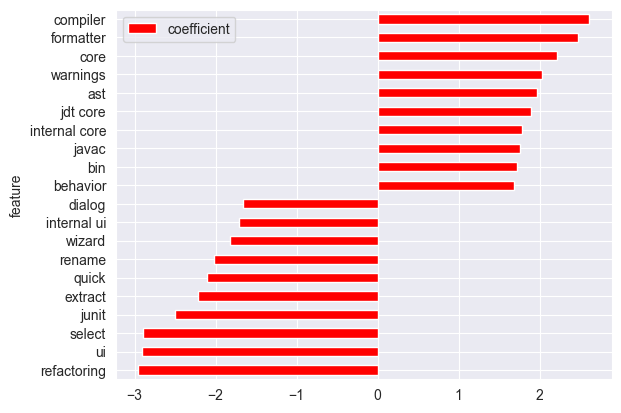

In [42]:
#core_ui.set_index("feature").plot.barh(color=[['red']*10 + ['green']*10])
core_ui.set_index("feature").plot.barh(color=['red'])
plt.show()

We have just found the features that are important for the whole SVM model to choose between Core and UI. But this does not indicate which features are important to identify a bug that can be categorized as Core given any bug report. If we want to get these features for the Core component and consider the previous matrix, we need indices 5, 6, 7, and 8. With this strategy, we have ignored the difference between APT and Core. To take this into account, we need to subtract index 0.

In [43]:
c = svc.coef_

# coef = (c[5] + c[6] + c[7] + c[8] - c[0]).A[0]
coef = (c[5] + c[6] + c[7] + c[8] - c[0]).toarray()[0]

vocabulary_positions = coef.argsort()
vocabulary_positions

array([ 792,  994, 3095, ..., 1696,  699,  593])

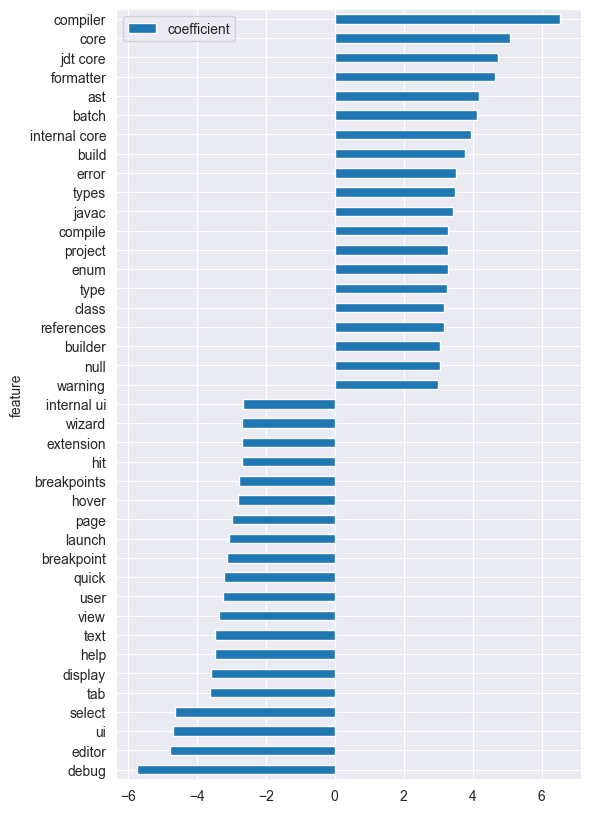

In [44]:
top_words = 20
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()
core = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef], 
                       columns=["feature", "coefficient"]).sort_values("coefficient")

#core.set_index("feature").plot.barh(figsize=(6, 10), color=[['red']*top_words + ['green']*top_words])
core.set_index("feature").plot.barh(figsize=(6, 10))
plt.show()

We  can use the methods described in this blueprint to make the results of the SVM model transparent and explainable. In many projects, this has proved to be valuable as it takes away the "magic" and the subjectivity of machine learning.

This works quite well, but we do not yet know how sensitive the model is to changes in certain words. This is a more complicated question that we will try to answer in the next section.

---
<a name='7.3'></a><a id='7.3'></a>
# 7.3 Blueprint: Using LIME to Explain the Classification Results
<a href="#top">[back to top]</a>


[LIME](https://homes.cs.washington.edu/~marcotcr/blog/lime/) is an acronym for “Local Interpretable Model-Agnostic Explanations” and is a popular framework for explainable machine learning. It was conceived at the University of Washington and is publicly available on [GitHub](https://github.com/marcotcr/lime).

It works locally by taking a look at each prediction separately. This is achieved by modifying the input vector to find the local components that the predictions are sensitive to.

LIME does not depend on a specific machine learning model and can be applied to a multitude of problems. Not every model qualifies; the model needs to predict the probabilities of the categories.

LIME wants text as input and classification probabilities as output, so we arrange the vectorizer and classifier in a pipeline.

In [45]:
pipeline = make_pipeline(tfidf, svc)
pipeline

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=10, ngram_range=(1, 2),
                                 stop_words='english')),
                ('svc',
                 SVC(C=1, kernel='linear', probability=True, random_state=42))])

The pipeline should be able to make predictions if we give it some text.

In [46]:
proba = pipeline.predict_proba(["compiler not working"])
proba

array([[6.01091225e-03, 9.18666301e-01, 1.01700374e-02, 4.12318693e-04,
        1.31560366e-02, 5.15843937e-02]])

In [47]:
for i, x in enumerate(proba[0]):
    print(f"{x:.3f} {class_names[i]}")

0.006 APT
0.919 Core
0.010 Debug
0.000 Doc
0.013 Text
0.052 UI


The classifier suggests with very high probability to put this in class 2, which is Core.

In [48]:
print(f"{class_names[np.argmax(proba)]}: {np.max(proba)}")

Core: 0.9186663014007419


### Using LIME

Create an explainer, which is one of the central elements of LIME and is responsible for explaining individual predictions.

This explains text classifiers. Currently, we are using an exponential kernel on cosine distance, and restricting explanations to words that are present in documents.

In [49]:
explainer = LimeTextExplainer(class_names=class_names)
explainer

Check the DataFrame for classes that have been wrongly predicted.

In [50]:
er[er["predicted"] != er["actual"]].head(5)

,index,text,actual,predicted,APT,Core,Debug,Doc,Text,UI,max_probability
4,4,ClassCastException in CompletionEngine Build 2...,Core,UI,0.004841,0.163564,0.100797,0.003383,0.171710,0.555705,0.555705
9,9,generated source folder should be marked as de...,APT,UI,0.015638,0.434162,0.025722,0.001126,0.075706,0.447646,0.447646
24,24,Delete fails and Blocks the application I copi...,Text,Debug,0.014969,0.140004,0.559113,0.002081,0.152345,0.131488,0.559113
25,25,Syntax highlighting glitch Create a class call...,UI,Core,0.006960,0.508297,0.059812,0.004770,0.283489,0.136672,0.508297
28,28,HTML format hovering help Hi;; We are developi...,Text,UI,0.008915,0.085285,0.012169,0.052156,0.260439,0.581036,0.581036


Examine record 21.

In [51]:
id = 21
print('Document id: %d' % id)
print('Predicted class =', er.iloc[id]["predicted"])
print('True class: %s' % er.iloc[id]["actual"])

Document id: 21
Predicted class = UI
True class: UI


### explainer.explain_instance API

```
explainer.explain_instance(
    text_instance,
    classifier_fn,
    labels=(1,),
    top_labels=None,
    num_features=10,
    num_samples=5000,
    distance_metric='cosine',
    model_regressor=None,
)
```

Generates explanations for a prediction.

First, we generate neighborhood data by randomly hiding features from
the instance. We then learn
locally weighted linear models on this neighborhood data to explain
each of the classes in an interpretable way.

Args:
* text_instance: raw text string to be explained.
* classifier_fn: classifier prediction probability function, which
    takes a list of d strings and outputs a (d, k) numpy array with
    prediction probabilities, where k is the number of classes.
    For ScikitClassifiers , this is classifier.predict_proba.
* labels: iterable with labels to be explained.
* top_labels: if not None, ignore labels and produce explanations for
    the K labels with highest prediction probabilities, where K is
    this parameter.
* num_features: maximum number of features present in explanation
* num_samples: size of the neighborhood to learn the linear model
distance_metric: the distance metric to use for sample weighting,
    defaults to cosine similarity
* model_regressor: sklearn regressor to use in explanation. Defaults
to Ridge regression in LimeBase. Must have model_regressor.coef_
and 'sample_weight' as a parameter to model_regressor.fit()

Returns:
* An Explanation object (see explanation.py) with the corresponding
explanations.

---
Use LIME to explain this model.

In [52]:
exp = explainer.explain_instance(
    text_instance=result.iloc[id]["text"], 
    classifier_fn=pipeline.predict_proba, 
    num_features=10, 
    labels=[1, 5]
)

print('Explanation for class %s' % class_names[1])
print('\n'.join(map(str, exp.as_list(label=1))))
print()
print('Explanation for class %s' % class_names[5])
print('\n'.join(map(str, exp.as_list(label=5))))

Explanation for class Core
('editor', -0.1056752892020739)
('like', -0.09746976680961088)
('Eclipse', 0.0726978734224568)
('format', 0.0693053981467134)
('function', -0.051175423671351174)
('Thanks', -0.047965832914136274)
('options', -0.027120038860922163)
('doesnt', 0.017818107863383954)
('provides', 0.01630337605753167)
('really', 0.014405273638762086)

Explanation for class UI
('format', -0.22404128977665672)
('Visual', 0.09377924398771598)
('Eclipse', -0.080792181036473)
('Hi', 0.08016463218349945)
('Thanks', 0.07829372997775476)
('work', 0.07391401217377778)
('options', 0.0532530834659368)
('code', -0.040918866957785315)
('really', 0.04059577977495484)
('provides', 0.030590253981222233)


With LIME, you can extend the analysis to more classes and create a graphics representation of their specific words.

In [ ]:
exp = explainer.explain_instance(
    result.iloc[id]["text"], 
    pipeline.predict_proba, 
    num_features=6, 
    top_labels=3
)

print(exp.available_labels())

In [ ]:
exp.show_in_notebook(text=False)

---
LIME can also help in finding representative samples that help you interpret the model performance as a whole. The feature is called `submodular_pick`.

`submodular_pick` saves a representative sample of explanation objects using SP-LIME, as well as saving all generated explanations.

    class lime.submodular_pick.SubmodularPick(
        explainer, 
        data, 
        predict_fn, 
        method='sample', 
        sample_size=1000, 
        num_exps_desired=5, 
        num_features=10, 
        **kwargs
    )

* https://github.com/marcotcr/lime/blob/master/lime/submodular_pick.py
* https://lime-ml.readthedocs.io/en/latest/lime.html#lime-submodular-pick-module
* https://github.com/marcotcr/lime/blob/master/doc/notebooks/Submodular%20Pick%20examples.ipynb

In [ ]:
# %%time
# print("Start")

# ## This take a really long time to run!

# lsm = submodular_pick.SubmodularPick(
#     explainer, 
#     er["text"].values, 
#     pipeline.predict_proba, 
#     sample_size=100,
#     num_features=20,
#     num_exps_desired=5
# )

# print("Done")

---
<a name='7.4'></a><a id='7.4'></a>
# 7.4 Blueprint: Using ELI5 to Explain the Classification Results
<a href="#top">[back to top]</a>

[ELI5](https://github.com/TeamHG-Memex/eli5) needs a model that has been trained with libsvm.

In [ ]:
# ELI5 needs a libsvm-based model.
svm = SGDClassifier(
    loss='hinge', 
    max_iter=1000, 
    tol=0.001, # 1e-3, 
    random_state=42
)
svm

In [ ]:
svm.fit(X_train_tf, Y_train)
print("Done fitting svm model")

In [ ]:
Y_pred_svm = svm.predict(X_test_tf)

print(classification_report(Y_test, Y_pred_svm))

### eli5.show_weights

    eli5.show_weights(
        svm, 
        top=10, 
        vec=tfidf, 
        target_names=class_names
    )

Return an explanation of estimator parameters (weights). Use this function
to show classifier weights in IPython.

In [ ]:
# eli5.show_weights(
#     svm, 
#     top=10, 
#     vec=tfidf, 
#     target_names=class_names
# )

ELI5 can also explain individual observations:

In [ ]:
# eli5.show_prediction(
#     svm, 
#     X_test.iloc[21],  
#     vec=tfidf, 
#     target_names=class_names
# )

ELI5 is an easy-to-use software library for understanding and visualizing the decision logic of classifiers, but it also suffers from the shortcomings of the underlying LIME algorithm, such as explainability by example only. 

---
<a name='7.5'></a><a id='7.5'></a>
# 7.5 Blueprint: Using Anchor to Explain the Classification Results
<a href="#top">[back to top]</a>

Like LIME, Anchor is model agnostic and works for any black-box model. As a tool for explanations, it creates rules, the so-called anchors, which explain the behavior of the model. Reading these rules, you will not only be able to explain a pre‐ diction of the model but also predict in the same way as the model has learned to.

Compared to LIME, Anchor has considerable advantages for better explaining the models with the rules. However, the software itself is quite new and still a work in progress. Not all examples were working for us, so we chose a selection of methods that help in interpreting the classification model.

<a name='7.5.1'></a><a id='7.5.1'></a>
## 7.5.1 Using the Distribution with Masked Words
<a href="#top">[back to top]</a>

There are different ways Anchor can be used. We start with the so-called unknown distribution. Anchor will explain how a model makes a decision by replacing existing tokens that are supposed to be unimportant for the prediction with the word unknown.

To create (semantic) variance in the text, Anchor uses spaCy’s word vectors and needs a spaCy model that includes these vectors, like `en_core_web_lg`.

An anchor explanation is a rule that sufficiently “anchors” the prediction locally – such that changes to the rest of the feature values of the instance do not matter. In other words, for instances on which the anchor holds, the prediction is (almost) always the same.

https://github.com/marcotcr/anchor

https://github.com/marcotcr/anchor/blob/master/notebooks/Anchor%20for%20text.ipynb



In [ ]:
# Restart the random-number generator.
np.random.seed(42)

explainer_unk = anchor_text.AnchorText(
    nlp, 
    class_names, 
    use_unk_distribution=True
)

explainer_unk

Check the predicted results and alternatives and compare them to the ground truth. 

`predicted_class_ids` contains the indices of the predicted classes with decreasing probability, so the element 0 is the prediction, and element 1 is its closest competitor.

In [ ]:
text = er.iloc[21]["text"]
actual = er.iloc[21]["actual"]

# We want the class with the highest probability and must invert the order
predicted_class_ids = np.argsort(pipeline.predict_proba([text])[0])[::-1]
pred = explainer_unk.class_names[predicted_class_ids[0]]

alternative = explainer_unk.class_names[predicted_class_ids[1]]

print(f'predicted {pred}, alternative {alternative}, actual {actual}')

---
Next, we let the algorithm find the rules for the predictions. The parameters are the same as for LIME earlier.

* https://github.com/marcotcr/anchor/blob/master/notebooks/Anchor%20for%20text.ipynb


In [ ]:
# Examine text
text

In [ ]:
# Explaining a prediction
exp_unk = explainer_unk.explain_instance(
    text=text, 
    classifier_fn=pipeline.predict, 
    threshold=0.95
)

exp_unk

Everything is now contained in the explainer, so we can query the explainer to find out about the inner workings of the model.

In [ ]:
print(f'Rule: {" AND ".join(exp_unk.names())}')
print(f'Precision: {exp_unk.precision()}')

---
Find typical examples that the model would classify as Core:

In [ ]:
print(f'Made-up examples where anchor rule matches and model predicts {pred}\n')
print('\n'.join([x[0] for x in exp_unk.examples(only_same_prediction=True)]))

---
Ask for examples where the rule matches but the model predicts the wrong class.


In [ ]:
print(f'Made-up examples where anchor rule matches and model predicts {alternative}\n')
print('\n'.join([x[0] for x in exp_unk.examples(partial_index=0, only_different_prediction=True)]))

<a name='7.5.2'></a><a id='7.5.2'></a>
## 7.5.2 Working with Real Words
<a href="#top">[back to top]</a>

**Note: This section is broken**

By substituting `use_unk_distribution=False` in the original constructor of the explainer, we can tell Anchor to use real words (similar to the one it is substituting by using the word vectors in spaCy), and observe the behavior of the model.

    anchor_text.AnchorText(
        nlp: spacy object
        class_names: list of strings
        use_unk_distribution: 
            If True, the perturbation distribution will just replace words randomly with mask_string.
            If False, words will be replaced by similar words using word embeddings
        mask_string: String used to mask tokens if use_unk_distribution is True.
    )

### Explaining a prediction without unknown

In [ ]:
# %%time

# np.random.seed(42)

# # https://github.com/marcotcr/anchor/blob/master/anchor/anchor_text.py#L101
# explainer_no_unk = anchor_text.AnchorText(
#     nlp, 
#     class_names, 
#     use_unk_distribution=False
# )

In [ ]:
# %%time
# # This results in a std::bad_alloc error on COLAB

# # https://github.com/marcotcr/anchor/blob/master/anchor/anchor_text.py#L168
# exp_no_unk = explainer_no_unk.explain_instance(
#     text, 
#     pipeline.predict, 
#     threshold=0.95,
#     batch_size=5 # the higher, the more memory needed
# )

In [ ]:
# %%time

# print(f'Rule: {" AND ".join(exp_no_unk.names())}')
# print(f'Precision: {exp_no_unk.precision()}')

# print('Anchor: %s' % (' AND '.join(exp_no_unk.names())))
# print('Precision: %.2f' % exp_no_unk.precision())
# print()
# print('Examples where anchor applies and model predicts %s:' % pred)
# print()
# print('\n'.join([x[0] for x in exp_no_unk.examples(only_same_prediction=True)]))
# print()
# print('Examples where anchor applies and model predicts %s:' % alternative)
# print()
# print('\n'.join([x[0] for x in exp_no_unk.examples(partial_index=0, only_different_prediction=True)]))

### Numerical for show in notebook


In [ ]:
# def predict_numerical(text):
#     res = pipeline.predict(text)
#     n = np.array([str(class_names.index(r)) for r in res])
#     return n

By substituting `use_unk_distribution=False` in the original constructor of the explainer, we can tell Anchor to use real words (similar to the one it is substituting by using the word vectors from spaCy) and observe the behavior of the model:

In [ ]:
# %%time
# print("Start")

# # This takes a long time to run!
# explainer_num = anchor_text.AnchorText(
#     nlp, 
#     list(range(6)), 
#     use_unk_distribution=False,
# )

In [ ]:
# %%time
# #if not IS_COLAB:
# exp_num = explainer_num.explain_instance(text, predict_numerical, threshold=0.95)

# exp_num

In [ ]:
# %%time
# # if not IS_COLAB:
# predicted_class_ids = np.argsort(pipeline.predict_proba([text])[0])[::-1]
# pred = explainer_num.class_names[predicted_class_ids[0]]
# alternative = explainer_num.class_names[predicted_class_ids[1]]
# print(f'predicted {pred}, alternative {alternative}')

In [ ]:
# %%time
# exp_num.show_in_notebook()